In [45]:
import numpy as np
import imageio as imio
import matplotlib.pyplot as plt
import tensorflow as tf
import datetime

if tf.__version__.startswith("2."):
  import tensorflow.compat.v1 as tf
  tf.compat.v1.disable_v2_behavior()
  tf.compat.v1.disable_eager_execution()

Instructions for updating:
non-resource variables are not supported in the long term


Si tienes algún error al ejecutar la celda anterior verifica que tu ambiente de anaconda tenga las librerías necesarias.

# Clasificación con K-nearest neighbors
En este notebook vamos a implementar K-nearest neighbor, nuestro algoritmo va a **clasificar** a que raza pertenece la imagen de un perro, para entrenar nuestro algoritmo vamos a utilizar un set de datos contiene imagenes de 120 razas de perros, en total son 10,222 imagenes.

Data: [Dog Breed Identification](https://www.kaggle.com/c/dog-breed-identification/data)

#### Pre-procesamiento

El pre-procesamiento ya fue realizado y el dataset preparado y esta listo para usarse, para esto se aplico un proceso conocido como "transfer learning" usando la red neuronal "Inception" de Google(tema a cubrirse en proximas clases)  , para esta tarea ignoremos este detalle  y pensemos que se nos da un dataset con features donde cada columna representa una característica de entrada importante,pero no nos interesa conocer los detalles. 

Estas features/características fueron almacenadas en un matriz de numpy.

En esta parte del notebook solo hay que ejecutar las celdas para cargar los datos, estos datos van a servir de entrada para nuestra implementación de K-nearest neighbors con tensorflow.

### Referencias opcionales para transfer learning y "Google inception"
##### Inception
https://www.tensorflow.org/tutorials/image_recognition

https://research.googleblog.com/2016/03/train-your-own-image-classifier-with.html

##### Transfer Learning
https://www.datacamp.com/community/tutorials/transfer-learning

In [19]:
images_inception_features = './pre-processing/training_inception_features_array.npy'
training_image_labels_array = './pre-processing/training_image_labels_array.npy'
training_image_names_array = './pre-processing/training_image_names_array.npy'

In [24]:
TRAIN_DICTIONARY_KEYS = ["images", "label","features"]

training_set_dict = dict()
    
training_set_dict['images_name'] = np.load(training_image_names_array, allow_pickle=True)
training_set_dict['label'] = np.load(training_image_labels_array, allow_pickle=True)
training_set_dict['features'] = np.load(images_inception_features, allow_pickle=True)


#  K-Nearest Neighbors

La data la vamos a manejar en los siguientes 3 arreglos: 

- features    : features de la imagen dadas por google Inception
- labels      : label de la imagen, identifica que raza es
- images_name : nombre de la imgen original, si descargan el dataset con link en la descripcion pueden buscar la imagen original por este nombre.

In [25]:
## Cargamos las features y las labes de cada feature
features = training_set_dict['features']
labels = training_set_dict['label']
images_name = training_set_dict['images_name']

In [26]:
len(features)

10222

Las labels pertenecientes a las features tienen el mismo indice, Ejemplo:

Label:  golden_retriever
Nombre:  0021f9ceb3235effd7fcde7f7538ed62


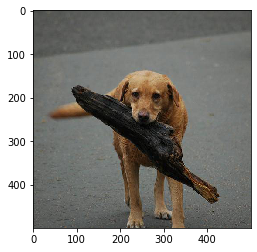

In [27]:
# Indice 4

print('Label: ',labels[4])

print('Nombre: ',images_name[4])

img = imio.imread('./data/train/'+images_name[4]+'.jpg')
plt.imshow(img)


### Implementa tu codigo de  K-Neighbors aqui:

El siguiente es un ejemplo de como puedes  definir tu función para predecir la raza sobre un punto x_predict ,a través de uscar los "k" vecinos mas cercanos en X_train y devolver como predicción el "y" que mas se repite(la moda) correspondiente a esos "k" valores de X_train , este "y" estará dado por Y_train.

Un ejemplo  de KNN en tensorflow: http://marubon-ds.blogspot.com/2017/09/knn-k-nearest-neighbors-by-tensorflow.html (este tiene diferencias, usar como guía no copiar literal, por ejemplo este usa una métrica de distancia diferente a la que debemos usar: distancia euclidiana )


#### Instrucciones:
1. Implementar KNN
2. Agregar el grafo de tensorboard
3. Ejecutar el modelo con las 2 imagenes de prueba.

In [56]:
def predecir_raza_KNN(X_predict, X_train, Y_train,k):
    tf.reset_default_graph()
    Y_train = Y_train.reshape(-1, 1)

    xTrain = tf.placeholder(tf.float32, X_train.shape, "x_train")
    yTrain = tf.placeholder(tf.string, Y_train.shape, "y_train")
    xPredict = tf.placeholder(tf.float32, X_predict.shape, "x_predict")

    feedDict = {xTrain: X_train, yTrain: Y_train, xPredict: X_predict}

    with tf.name_scope("euclidean_distance"):
        euclideanDistance = tf.reduce_mean(tf.math.sqrt(tf.math.square(xTrain - xPredict)), axis = 1)
        inverseEuclideanDistance = tf.negative(euclideanDistance)
    with tf.name_scope("knn"):
        _, topKi = tf.nn.top_k(inverseEuclideanDistance, k = k)
        topK = tf.gather(yTrain, topKi)
        topK = tf.reshape(topK, [1, k])[0]
    with tf.name_scope("knn_mode"):
        values, _, counts = tf.unique_with_counts(topK)
        modeIndex = tf.argmax(counts)
        mode = tf.gather(values, modeIndex)
    with tf.Session() as session:  
        writer = tf.summary.FileWriter("./logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "_k=" + str(k), session.graph)
        yHat = session.run(mode, feed_dict = feedDict)

    return yHat.decode("utf-8") #asigna a "y" la predicción resulatnte

![text](graphs/dogs-race-graph.png)

## Probamos el algoritmo con nuevas imagenes 

Como buena practica luego de entrenar nuestro algoritmo, lo probamos con imagenes que no ha visto antes 

In [57]:
test_features = np.load('./data/test/test_inception_features_array.npy')

### Prueba 1

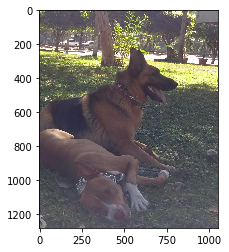

In [58]:
img_test = imio.imread('./data/test/test1.jpg')
plt.imshow(img_test)

In [59]:
predict_image = test_features[0]

## Ejecuta tu modelo con la entrada de `predict_image`
# Deberiamos obtener: german_shepherd

predecir_raza_KNN(predict_image, features, labels, 11)

'german_shepherd'

### Prueba 2

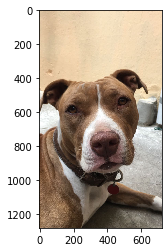

In [60]:
img_test = imio.imread('./data/test/test2.jpg')
plt.imshow(img_test)

In [61]:
## Ejecuta tu modelo con la entrada de `predict_image`
# Deberiamos obtener: american_staffordshire_terrier #
predict_image = test_features[1]

predecir_raza_KNN(predict_image, features, labels, 11)

'american_staffordshire_terrier'